### 1. Read in data 

In [1]:
%matplotlib notebook
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=16)
from Gridding_old import *
from Imaging_core_new import *

In [2]:
#########  Read in visibilities ##########
data = np.genfromtxt('out_barray_6d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[0]
v_original = data.T[1]
w_original = -data.T[2]
V_original = data.T[3] + jj*data.T[4]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 900 # image size on x-axis
Y_size = 900 # image size on y-axis
X_min = -np.pi/60. #You can change X_min and X_max in order to change the pixel size.
X_max = np.pi/60.
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -np.pi/60. #You can change Y_min and Y_max in order to change the pixel size.
Y_max = np.pi/60.
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  23.999999999999996  arcsec


### 2. determine the number of w planes 

In [3]:
Nfft = 1800
W = 14
R = W//2
x0 = 0.25 
M = 32
w_max = max(w)
w_min = min(w)
N_w = 30
w_values = [(w_max - w_min)/N_w*i for i in range(-R+1, N_w+R+1)]
dw = w_values[2]-w_values[1]
Nw_2R = len(w_values)
def nearest_wlayer(w_values,w,dw):
    #find the index of the w plane for each w value
    ind = []
    for i in range(n_uv):
        for j in range(len(w_values)):
            diff = w[i]-w_values[j]
            if diff >= 0 and diff <= dw:
                ind += [j]
    return ind

ind = nearest_wlayer(w_values,w,dw)


In [4]:
#W = 14
#x0 = 0.25
#Nw_2R, w_values, dw = Wplanes(W, X_max, Y_max, w, x0)
#ind = find_nearestw(w_values, w)

### 3. w-stacking

#### 3-d Gridding

In [5]:
M = 32
h = np.array([1.0004538705524384, 1.0018167571888508, 1.0040924910037743,
       1.0072874777218557, 1.0114107286991567, 1.01647390462776  ,
       1.0224913722498286, 1.0294802744795768, 1.0374606144276517,
       1.0464553539230763, 1.056490527234162 , 1.0675953708026737,
       1.0798024699261606, 1.093147923452921 , 1.1076715276939142,
       1.1234169809074428, 1.140432109877257 , 1.1587691202845547,
       1.1784848727711617, 1.1996411868070795, 1.2223051747130087,
       1.2465496084500247, 1.2724533220773244, 1.3001016530981768,
       1.329586926267655 , 1.3610089838276185, 1.39447576656945  ,
       1.4301039506085578, 1.4680196452926424, 1.5083591582649176,
       1.5512698343715243, 1.5969109758478965, 1.6454548520515748,
       1.6970878079399683, 1.75201148153333  , 1.8104441417699515,
       1.8726221594683596, 1.9388016255784695, 2.0092601325509496,
       2.084298736505226 , 2.1642441199585236, 2.249450977221874 ,
       2.340304647209209 , 2.43722402138255  , 2.5406647579157084,
       2.6511228369532525, 2.7691384961307297, 2.8953005903750744,
       3.0302514254996726, 3.1746921213372645, 3.3293885672199095,
       3.495178040638391 , 3.6729765690316256, 3.8637871250289186,
       4.068708757277644 , 4.288946772448109 , 4.525824099360779 ,
       4.780793983712307 , 5.05545418191414  , 5.351562845481708 ,
       5.671056313665354 , 6.016069062109771 , 6.388956089864428 ,
       6.792318066738979 ])


#### Gridding on w

In [6]:
bEAM = np.ones(n_uv)
V_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
beam_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
u_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
v_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
R = W//2
for w_i in range(n_uv):
    tempw = (w[w_i] - w_values[ind[w_i]])/dw
    #print (tempw)
    w_plane = ind[w_i]
    C_w = calc_gridder_as_C(h, x0, np.asarray([tempw]), W)
    for n in range(-R+1,R+1):
        #print (tempw,w_i,w_plane,w_plane+n)
        V_wgrid[w_plane+n] += [C_w[n+R-1,0] * V[w_i]]
        u_wgrid[w_plane+n] += [u[w_i]]
        v_wgrid[w_plane+n] += [v[w_i]]
        beam_wgrid[w_plane+n] += [C_w[n+R-1,0] * bEAM[w_i]]

/Users/yehaoyang/Documents/Wide-field-Nfacet/Gridding_old.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C[:,m] = np.linalg.lstsq(B, rhs)[0]


In [7]:
for i in range(Nw_2R):
    del(V_wgrid[i][0])
    del(u_wgrid[i][0])
    del(v_wgrid[i][0])
    del(beam_wgrid[i][0])

#### Gridding on u,v

In [8]:
im_size = 1800
I_image = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)
B_image = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)
B_grid = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_) 
V_grid = np.zeros((Nw_2R,im_size,im_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('This is the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    u_grid = u_update * 2 * (X_max - X_min) + im_size//2
    v_grid = v_update * 2 * (Y_max - Y_min) + im_size//2
    #bEAM = np.ones(len(V_update))
    for k in range(0,len(V_wgrid[w_ind])):
        tempu = u_grid[k] - np.floor(u_grid[k])
        tempv = v_grid[k] - np.floor(v_grid[k])
        C_u = calc_gridder_as_C(h, x0, np.asarray([tempu]), W)
        C_v = calc_gridder_as_C(h, x0, np.asarray([tempv]), W)
        u_index = np.int(np.floor(u_grid[k]))
        v_index = np.int(np.floor(v_grid[k]))
        for mm in range(-R+1,R+1):
            for n in range(-R+1,R+1):
                V_grid[w_ind,u_index+mm,v_index+n] += C_u[mm+R-1,0] * C_v[n+R-1,0] * V_update[k]
                B_grid[w_ind,u_index+mm,v_index+n] += C_u[mm+R-1,0] * C_v[n+R-1,0] * beam_update[k] 
    
t2_stop = process_time()   
print("Elapsed time during the uv-gridding calculation in seconds:", t2_stop-t2_start)  

This is the  0 th level facet out of  44  w facets.

This is the  1 th level facet out of  44  w facets.

This is the  2 th level facet out of  44  w facets.

This is the  3 th level facet out of  44  w facets.

This is the  4 th level facet out of  44  w facets.

This is the  5 th level facet out of  44  w facets.

This is the  6 th level facet out of  44  w facets.

This is the  7 th level facet out of  44  w facets.

This is the  8 th level facet out of  44  w facets.

This is the  9 th level facet out of  44  w facets.

This is the  10 th level facet out of  44  w facets.

This is the  11 th level facet out of  44  w facets.

This is the  12 th level facet out of  44  w facets.

This is the  13 th level facet out of  44  w facets.

This is the  14 th level facet out of  44  w facets.

This is the  15 th level facet out of  44  w facets.

This is the  16 th level facet out of  44  w facets.

This is the  17 th level facet out of  44  w facets.

This is the  18 th level facet out of 

#### FFT, crop, phaseshift and sum

In [9]:
I_size = int(im_size*2*x0)
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)
for w_ind in range(Nw_2R):
    I_image += FFTnPShift(V_grid[w_ind], w_values[w_ind], X, Y, im_size, x0)
    B_image += FFTnPShift(B_grid[w_ind], w_values[w_ind], X, Y, im_size, x0)


FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
F

<IPython.core.display.Javascript object>


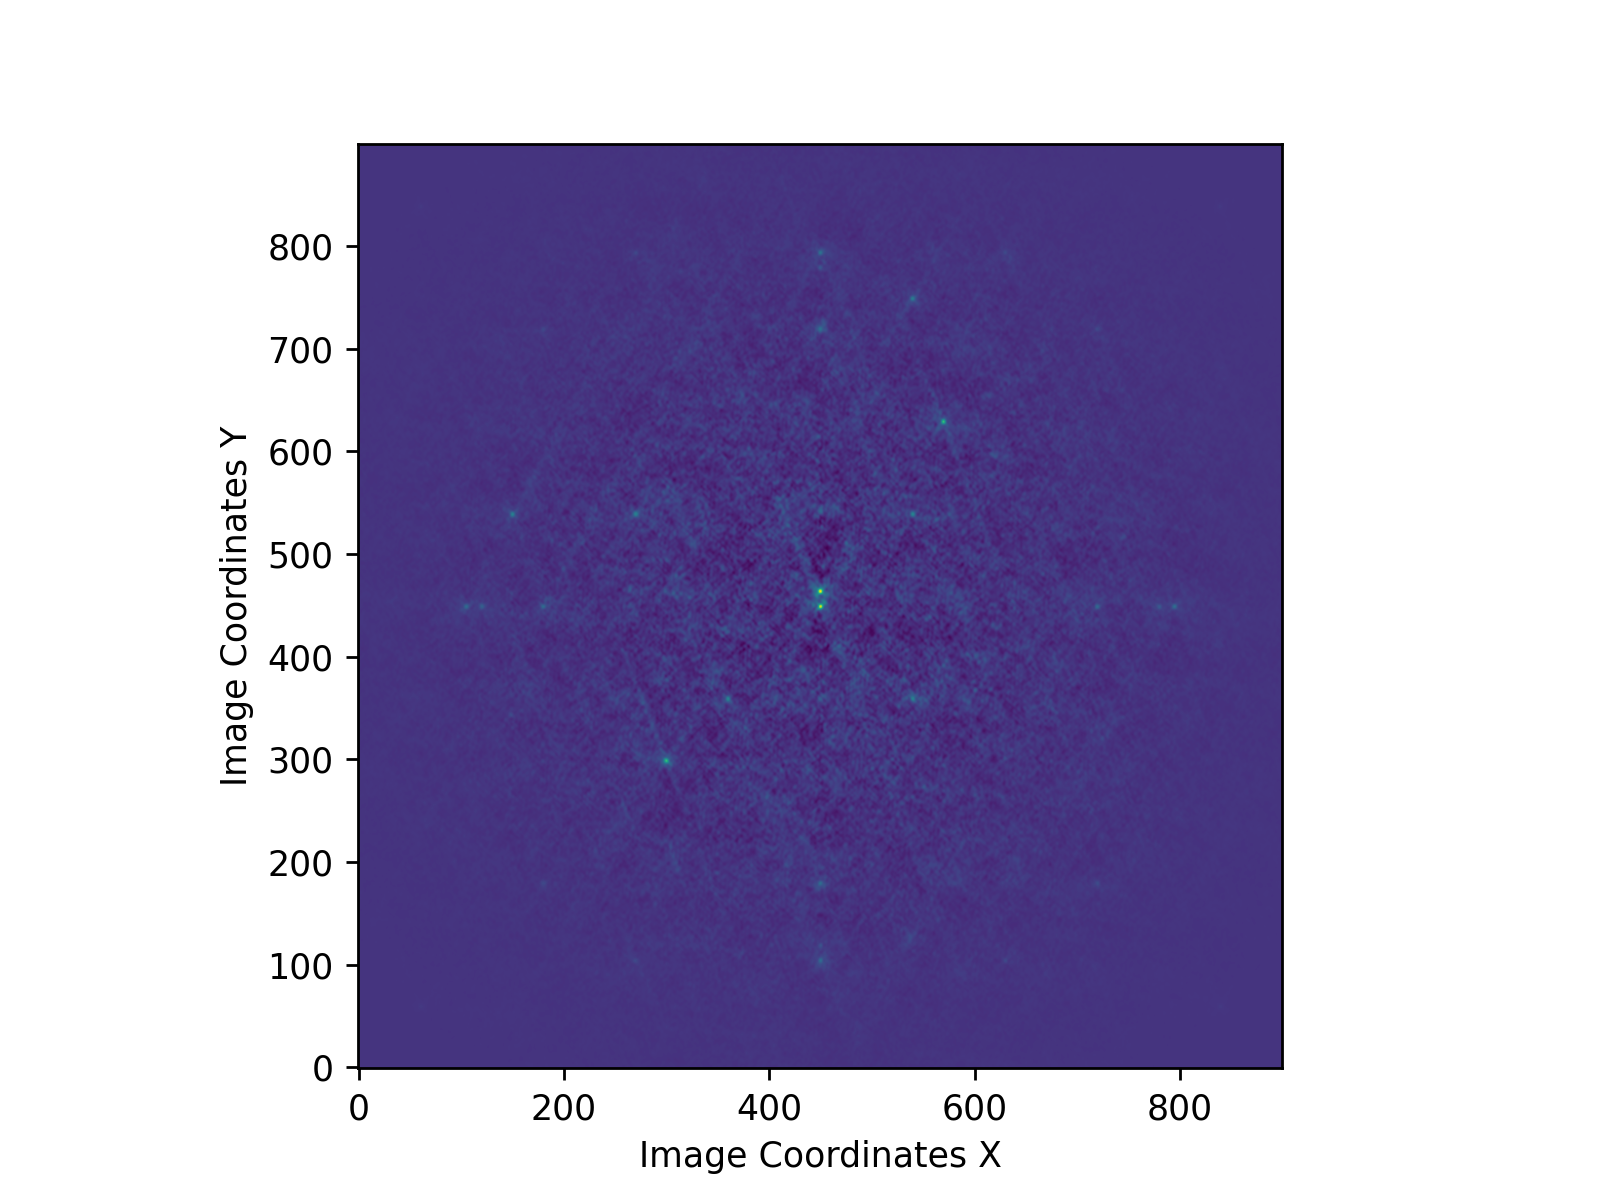

(1.0000000000000007+0j)

In [10]:
I_image_sum = image_rescale(I_image,im_size, n_uv)
B_image_sum = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_sum.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_image_sum[450,450]

#### Correcting functions h(x)h(y)

#### W=14, x0 = 0.25

In [11]:
I_image_sum_corrected = xy_correct_old(I_image_sum, h, im_size, W, M, x0=0.25)
B_image_sum_corrected = xy_correct_old(B_image_sum, h, im_size, W, M, x0=0.25)

#### Correcting function on z axis

In [12]:
Cor_gridz = z_correct_cal(X_min, X_max, Y_min, Y_max, dw, h, im_size, W, M, x0)
I_image_sum_zcorrected = z_correct(I_image_sum_corrected, Cor_gridz, im_size, x0=0.25)
B_image_sum_zcorrected = z_correct(B_image_sum_corrected, Cor_gridz, im_size, x0=0.25)

<IPython.core.display.Javascript object>


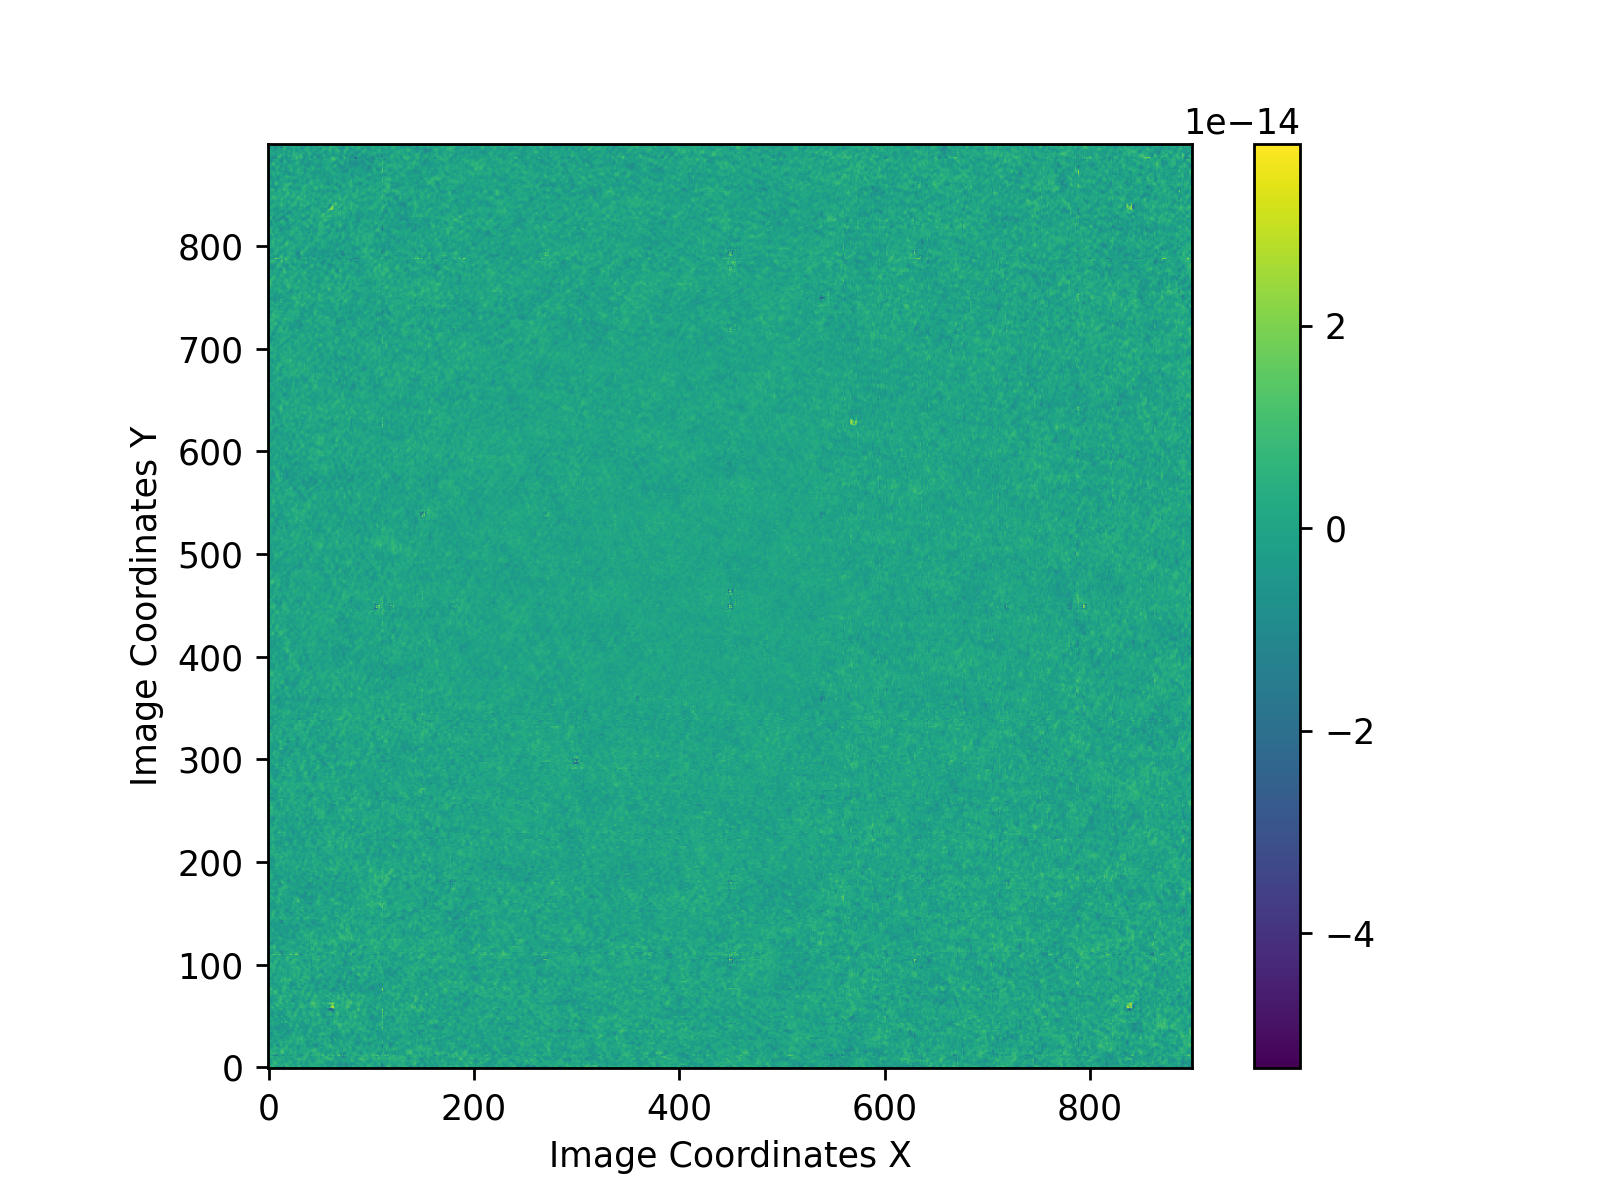

(1.000000000000001+0j)

In [13]:
I_DFT = np.loadtxt('I_DFT_900_out6db.csv', delimiter = ',')
plt.figure()
plt.imshow(np.rot90(I_image_sum_zcorrected.real - I_DFT,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.colorbar()
#plt.savefig('Zfaceting_DFT.png', bbox_inches = 'tight')
plt.show()

B_image_sum_corrected[450,450]